In [1]:
import getpass
import os
from dotenv import load_dotenv


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

load_dotenv()

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

In [5]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [6]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o-mini")

# Research agent and node
travel_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide information related to museums, travel guides etc. to the user. if the user asks about restaurants, foods or related questions, provide accurate data for the chef_agent to use.",
)
travel_node = functools.partial(agent_node, agent=travel_agent, name="travel_agent")

# chart_generator
chef_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You are an expert chef that knows everything about recipes, best restaurants and meals ingredients. You give users anything that is related with foods, restaurants and cuisines",
)
chef_node = functools.partial(agent_node, agent=chef_agent, name="chef_agent")


In [7]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool]
tool_node = ToolNode(tools)

In [8]:
# Either agent can decide to end
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

In [9]:
workflow = StateGraph(AgentState)

workflow.add_node("travel_agent", travel_node)
workflow.add_node("chef_agent", chef_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "travel_agent",
    router,
    {"continue": "chef_agent", "call_tool": "call_tool", END: END},
)
workflow.add_conditional_edges(
    "chef_agent",
    router,
    {"continue": "travel_agent", "call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "travel_agent": "travel_agent",
        "chef_agent": "chef_agent",
    },
)
workflow.add_edge(START, "travel_agent")
graph = workflow.compile()

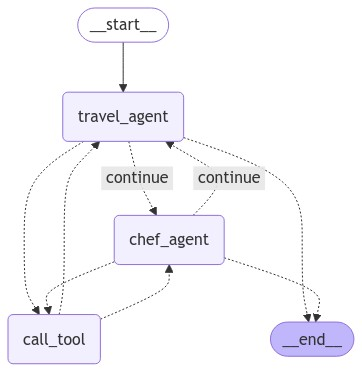

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
'''
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Give me a route to go in Rome to visit at least 2 different 5 star restaurants with best sea food"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")
'''

{'travel_agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_K2jcTgBLgM4dXs9dJU1zd2rt', 'function': {'arguments': '{"query": "best 5 star seafood restaurants in Rome"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_p79ds7Cx907f4scszbEUeZDC', 'function': {'arguments': '{"query": "Rome travel guide"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 239, 'total_tokens': 300, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, name='travel_agent', id='run-f626c575-c8fe-4bd2-8db7-762a6c31eb61-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'best 5 star seafood restaurants in

In [12]:
import streamlit as st
st.title("AI Travel and Food Assistant")

# User input
user_question = st.text_input("Ask a question about travel or food:")

if st.button("Submit"):
    if user_question:
        # Process the user's question
        events = graph.stream(
            {
                "messages": [HumanMessage(content=user_question)]
            },
            {
                "recursion_limit": 150
            },
        )
        
        # Display the result
        st.write("Assistant's response:")
        for event in events:
            st.write(f"{event}")
            print("-----")
    else:
        st.warning("Please enter a question.")

2024-10-10 17:08:25.722 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-10 17:08:25.749 
  command:

    streamlit run /Users/asimdag/Desktop/personal/CMPE492/.llmenv/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-10-10 17:08:25.750 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-10 17:08:25.750 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-10 17:08:25.750 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-10 17:08:25.750 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-10 17:08:25.751 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-10 17